In [1]:
# how fast are GPR surrogate models?
# Build a surrogate of:
# 1. phenomD
# 2. phenomHM
# and compare speed / valid accuracy

In [2]:
import george
from george import kernels
george.__version__

'0.3.1'

In [3]:
import glob

In [116]:
import time

In [4]:
from pycbc import waveform

In [5]:
import phenom

In [6]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# 1d fd test

In [34]:
hp, hc = waveform.get_fd_waveform(approximant="IMRPhenomD",
                        mass1=50,
                        mass2=10,
                        f_lower=20,
                        delta_f=1./16.,
                        inclination=0.,
                        distance=1e-19
                                 )

x = hp.sample_frequencies
y = np.real(hp.numpy())


mask = (x >= 20) & (x <= 100)
x = x[mask]
y = y[mask]

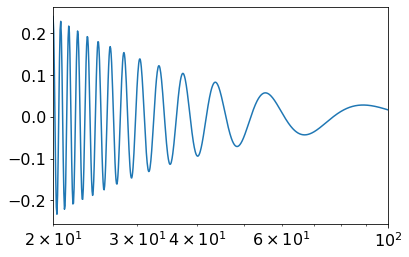

In [35]:
plt.figure()
# plt.plot(phenom.HztoMf(hp.sample_frequencies, 60), np.real(hp.numpy()))
plt.plot(x, y)
# plt.xlim(-500,100)
# plt.xlim(0.006,0.1)
plt.xlim(20,100)
# plt.yscale('log')
plt.xscale('log')

In [36]:
kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x)

In [37]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x)
# gp.compute(x, yerr)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-43626444.438728854
11926.787597098204


In [38]:
x_pred = x.copy()
pred, pred_var = gp.predict(y, x_pred, return_var=True)

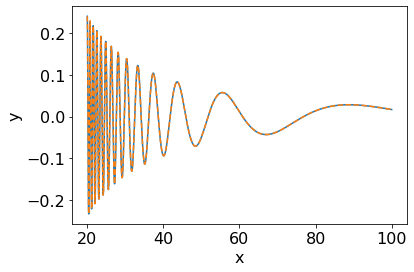

In [39]:
plt.figure()
plt.plot(x, y)
plt.plot(x_pred, pred, "--")
plt.xlabel("x")
plt.ylabel("y")
# plt.yscale('log')
plt.show()
plt.close()

# 1d td test

In [58]:
hp, hc = waveform.get_td_waveform(approximant="IMRPhenomD",
                        mass1=50,
                        mass2=10,
                        f_lower=20,
                        delta_t=1./1024.,
                        inclination=0.,
                        distance=1e-19
                                 )

x = hp.sample_times
y = np.real(hp.numpy())


mask = (x >= -0.1) & (x <= 0.02)
x = x[mask]
y = y[mask]

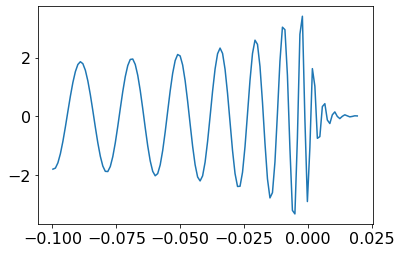

In [59]:
plt.figure()
# plt.plot(phenom.HztoMf(hp.sample_frequencies, 60), np.real(hp.numpy()))
plt.plot(x, y)
# plt.xlim(-500,100)
# plt.xlim(0.006,0.1)
# plt.xlim(20,100)
# plt.yscale('log')
# plt.xscale('log')

In [60]:
kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x)

In [61]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x)
# gp.compute(x, yerr)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-116945943536129.53
-228.27548422191003


In [62]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', 0.8739194628157455),
             ('kernel:k2:metric:log_M_0_0', -21.13596897699933)])

In [44]:
x_pred = x.copy()
pred, pred_var = gp.predict(y, x_pred, return_var=True)

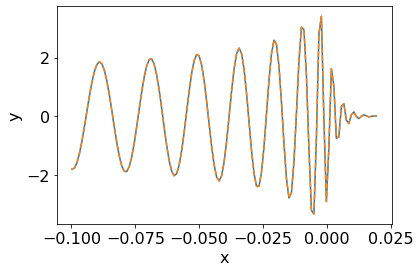

In [45]:
plt.figure()
plt.plot(x, y)
plt.plot(x_pred, pred, "--")
plt.xlabel("x")
plt.ylabel("y")
# plt.yscale('log')
plt.show()
plt.close()

# gen test data

In [74]:
def setup_2d_fd_data(qs, fmin=20, fmax=100):
    firstIteration=True
    for q in qs:
        mass1, mass2 = phenom.m1_m2_M_q(100, q)
        wfpars = dict(approximant="IMRPhenomD",
                     mass1=mass1, mass2=mass2,
                     f_lower=20, delta_f=1,
                     inclination=0,
                     distance=1e-19)
        hp, _ = waveform.get_fd_waveform(**wfpars)
        
        x = hp.sample_frequencies.numpy()[:]
        y = np.real(hp.numpy()[:])
        
        mask = (x >= fmin) & (x <= fmax)
        x = x[mask]
        y = y[mask]
        qs = np.ones_like(x) * q
        
        Xtmp = np.array([x, qs]).T
        Ytmp = y
        
        if firstIteration:
            X = Xtmp
            Y = Ytmp
            firstIteration=False
        else:
            X = np.concatenate((X, Xtmp))
            Y = np.concatenate((Y, Ytmp))
    return X, Y

In [200]:
def setup_2d_td_data(qs, tmin=-0.1, tmax=0.01, approximant="IMRPhenomHM"):
    firstIteration=True
    for q in qs:
        mass1, mass2 = phenom.m1_m2_M_q(50, q)
        wfpars = dict(approximant=approximant,
                     mass1=mass1, mass2=mass2,
                     f_lower=20, delta_t=1/2048.,
                     inclination=np.pi/3,
                     distance=1e-19)
        hp, _ = waveform.get_td_waveform(**wfpars)
        
        x = hp.sample_times.numpy()[:]
        y = np.real(hp.numpy()[:])
        
        mask = (x >= tmin) & (x <= tmax)
        x = x[mask]
        x = phenom.StoM(x, mass1+mass2)
        y = y[mask]
        qs = np.ones_like(x) * q
        
        Xtmp = np.array([x, qs]).T
        Ytmp = y
        
        if firstIteration:
            X = Xtmp
            Y = Ytmp
            firstIteration=False
        else:
            X = np.concatenate((X, Xtmp))
            Y = np.concatenate((Y, Ytmp))
    return X, Y

In [181]:
# X, Y = setup_2d_fd_data([1,2,3,4])
X, Y = setup_2d_td_data([1,2,3,4], tmin=-0.2)

In [182]:
X.shape

(1720, 2)

In [183]:
Y.shape

(1720,)

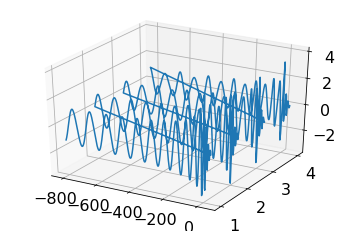

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], Y)

In [185]:
kernel = np.var(Y) * kernels.ExpSquaredKernel(1, ndim=2, axes=0)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=2, axes=1)
gp = george.GP(kernel)
# gp.compute(X, yerr)

In [186]:
%%time
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(Y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(Y, quiet=True)

# You need to compute the GP once before starting the optimization.
# gp.compute(X, yerr)
gp.compute(X)

# Print the initial ln-likelihood.
print(gp.log_likelihood(Y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(Y))

-2467.872415983899
1351.4758584344054
CPU times: user 1min 18s, sys: 5.01 s, total: 1min 23s
Wall time: 27.5 s


In [187]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:k1:log_constant', -0.8102127966583453),
             ('kernel:k1:k2:metric:log_M_0_0', 2.6455196844819353),
             ('kernel:k2:metric:log_M_0_0', -3.5524951197417516)])

In [188]:
# q_array = np.linspace(1, 4, 4)
# X_pred = np.array(np.meshgrid(np.linspace(-0.1, 0.01, 500),
#                              q_array
#                              )).reshape(2,-1).T
# pred, pred_var = gp.predict(Y, X_pred)
q_array = np.linspace(1, 4, 4)
X_pred = np.array(np.meshgrid(np.linspace(-400, 11, 500),
                             q_array
                             )).reshape(2,-1).T
pred, pred_var = gp.predict(Y, X_pred)

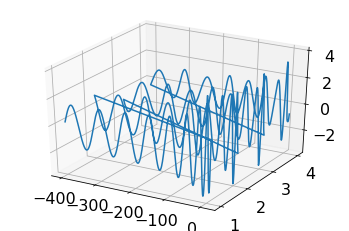

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:,0], X[:,1], Y)
ax.plot(X_pred[:,0], X_pred[:,1], pred)

In [212]:
def compare_model_with_gp(gp, q, tmin=-0.1, tmax=0.01):
    mass1, mass2 = phenom.m1_m2_M_q(50, q)
    wfpars = dict(approximant="IMRPhenomHM",
                 mass1=mass1, mass2=mass2,
                 f_lower=20, delta_t=1/2048.,
                 inclination=np.pi/3,
                 distance=1e-19)
    
    t1 = time.time()
    hp, _ = waveform.get_td_waveform(**wfpars)
    dtmodel = time.time() - t1
    
    x = hp.sample_times.numpy()[:]
    y = np.real(hp.numpy()[:])

    mask = (x >= tmin) & (x <= tmax)
    x = x[mask]
    y = y[mask]
    
    x = phenom.StoM(x, mass1+mass2)
    
    
    
    X_pred = np.array(np.meshgrid(x,
                                 q
                                 )).reshape(2,-1).T
    
    t1 = time.time()
    pred, pred_var = gp.predict(Y, X_pred)
    dtgp = time.time() - t1
    
    print('model dt = {:.3f} ms'.format(dtmodel * 1e3))
    print('gp dt = {:.3f} ms'.format(dtgp * 1e3))
    print('gp / model = {}'.format(dtgp/dtmodel))

    return x, y, X_pred[:,0], pred

model dt = 15.212 ms
gp dt = 95.281 ms
gp / model = 6.2635257977556265


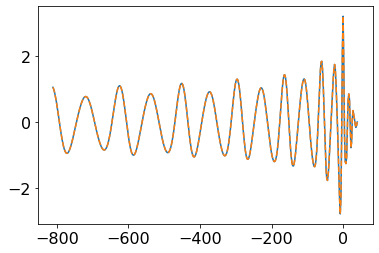

In [213]:
x,y, xgp, ygp = compare_model_with_gp(gp, 4, tmin=-0.2)
plt.figure()
plt.plot(x, y)
plt.plot(xgp, ygp, ls='--')